In [1]:
from azureml.core import Workspace, Experiment

ws = Workspace.get(name="quick-starts-ws-134619")
exp = Experiment(workspace=ws, name="udacity-project")

print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

run = exp.start_logging()

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code A5QRTWBDF to authenticate.
You have logged in. Now let us find all the subscriptions to which you have access...
Interactive authentication successfully completed.
Workspace name: quick-starts-ws-134619
Azure region: southcentralus
Subscription id: 6b4af8be-9931-443e-90f6-c4c34a1f9737
Resource group: aml-quickstarts-134619


In [2]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
# TODO: Create compute cluster
# Use vm_size = "Standard_D2_V2" in your provisioning configuration.
# max_nodes should be no greater than 4.

### YOUR CODE HERE ###
cpu_cluster_name="test-prj1"
try:
    cpu_cluster = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2', max_nodes=4)
    cpu_cluster = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

cpu_cluster.wait_for_completion(show_output=True)


Creating
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [3]:
from azureml.widgets import RunDetails
from azureml.train.sklearn import SKLearn
from azureml.train.hyperdrive.run import PrimaryMetricGoal
from azureml.train.hyperdrive.policy import BanditPolicy
from azureml.train.hyperdrive.sampling import RandomParameterSampling
from azureml.train.hyperdrive.runconfig import HyperDriveConfig
from azureml.train.hyperdrive.parameter_expressions import uniform,choice
import os
from azureml.core import Environment
from azureml.core import ScriptRunConfig

# Specify parameter sampler
ps = RandomParameterSampling(
    {
        "--C": uniform(0.5,1.5),
        '--max_iter': choice(range(50,200))
    }
)
sklearn_env=Environment.get(workspace=ws, name='AzureML-Tutorial')
# Specify a Policy
policy = BanditPolicy(evaluation_interval=2, slack_factor= 0.1)

if "training" not in os.listdir():
    os.mkdir("./training")

# Create a SKLearn estimator for use with train.py
compute_target = ws.compute_targets[cpu_cluster_name]
est = ScriptRunConfig(source_directory='./',
                      script='train.py',
                      arguments=['--C', 1, '--max_iter', 100],
                      compute_target=compute_target,
                      environment=sklearn_env)
# Create a HyperDriveConfig using the estimator, hyperparameter sampler, and policy.
hyperdrive_config = HyperDriveConfig(run_config=est,
hyperparameter_sampling=ps,
policy=policy,
primary_metric_name="Accuracy",
primary_metric_goal=PrimaryMetricGoal.MAXIMIZE,
max_total_runs=10,
max_concurrent_runs=4
)

In [4]:
# Submit your hyperdrive run to the experiment and show run details with the widget.
from azureml.widgets import RunDetails
experiment = Experiment(ws, "udacity-project")
hyperdrive_run = experiment.submit(hyperdrive_config)
RunDetails(hyperdrive_run).show()

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO'…

In [11]:
import joblib
# Get your best run and save the model from that run.
best_run = hyperdrive_run.get_best_run_by_primary_metric()
best_run_metrics = best_run.get_metrics()
parameter_values = best_run.get_details()['runDefinition']['arguments']

print('Best Run Id: ', best_run.id)
print('\n Accuracy:', best_run_metrics['Accuracy'])
print('\n C:',parameter_values[5])
print('\n max-iter:',parameter_values[3])

best_run.download_file(
    best_run.get_file_names()[-1],
    output_file_path='outputs'
)
best_hyperdrive_model = best_run.register_model(
    model_name="best_hyperdrive_model",
    model_path='outputs/best_hyperdrive_model.joblib',
   
)

Best Run Id:  HD_011b0b90-c4df-4d9b-9d2d-8fba2b31e6b0_3

 Accuracy: 0.9174506828528073

 C: 1.4083421679806372

 max-iter: 100


In [18]:
from azureml.data.dataset_factory import TabularDatasetFactory

# Create TabularDataset using TabularDatasetFactory
# Data is available at: 
path= "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/bankmarketing_train.csv"

### YOUR CODE HERE ###
ds = TabularDatasetFactory.from_delimited_files(path=path)

In [22]:
from train import clean_data
from sklearn.model_selection import train_test_split
from azureml.core.run import Run
from azureml.core import Dataset
# Use the clean_data function to clean your data.
x, y = clean_data(ds)
df=x.join(y)
os.makedirs('data',exist_ok=True)
local_path='data/prepared_data.csv'
df.to_csv(local_path)
workspace=Workspace(ws.subscription_id,ws.resource_group,ws._workspace_name)
datastore=workspace.get_default_datastore()
datastore.upload(src_dir='data',target_path='data')
ds2=Dataset.Tabular.from_delimited_files(datastore.path(local_path))
training, validation=ds2.random_split(percentage=0.8, seed=23)


Uploading an estimated of 1 files
Target already exists. Skipping upload for data/prepared_data.csv
Uploaded 0 files


In [23]:
from azureml.train.automl import AutoMLConfig

# Set parameters for AutoMLConfig
# NOTE: DO NOT CHANGE THE experiment_timeout_minutes PARAMETER OR YOUR INSTANCE WILL TIME OUT.
# If you wish to run the experiment longer, you will need to run this notebook in your own
# Azure tenant, which will incur personal costs.
automl_setting= {
    "experiment_timeout_minutes": 30,
    "n_cross_validations": 5,
    "primary_metric": "accuracy",
    "max_concurrent_iterations": 4}
automl_config = AutoMLConfig(
    task="classification",
    training_data=training,
    label_column_name='y',
    compute_target=compute_target,
    **automl_setting
)

In [24]:
# Submit your automl run
experiment=Experiment(ws,'automl')
automl_run=experiment.submit(automl_config,show_output=True)

Running on remote.
No run_configuration provided, running on test-prj1 with default configuration
Running on remote compute: test-prj1
Parent Run ID: AutoML_693c154d-b109-4456-8355-222b8667d497

Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetBalancing. Performing class balancing sweeping
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       ALERTED
DESCRIPTION:  To decrease model bias, please cancel the current run and fix balancing problem.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData
DETAILS:      Imbalanced data can lead to a falsely perceived positive effect of a model's accuracy because the input data has bias towards one class.
+---------------------------------+---------------------------------+----------------

In [25]:
RunDetails(automl_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [31]:
# Retrieve and save your best automl model.

### YOUR CODE HERE ###
best_run_aml,fitted_aml=automl_run.get_output()
# best_aml_model = best_run_aml.register_model(
#     model_name="best_automl_model",
#     model_path='outputs/best_automl_model.pkl',
   
# )
joblib.dump(fitted_aml,'outputs/best_automl_model.joblib')
x_test=validation.drop_columns(['y']).to_pandas_dataframe()
y_test=validation.keep_columns(['y'],validate=True).to_pandas_dataframe()
y_pred=fitted_aml.predict(x_test)


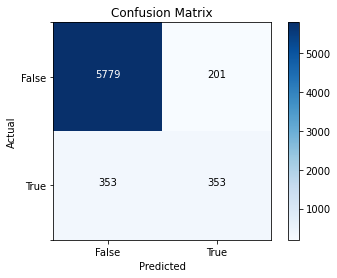

In [33]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import numpy as np
cf =confusion_matrix(y_test.values,y_pred)
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
class_labels = ['False','True']
tick_marks = np.arange(2)
plt.xticks(tick_marks,class_labels)
plt.yticks([-0.5,0,1,1.5],['','False','True',''])
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()


In [ ]:
cpu_cluster.delete()